In [ ]:
# suitable habitat for sable fish, as a case study
# first on 'current' habitat using historical data - glorys data
# later on 'projections' - dowsncaled data

In [3]:
import xarray as xr
import glob
import os
import fnmatch
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore') # filter some warning messages
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [4]:
# Generals
ldp = '/Users/sol/Documents/LargeData/QIN/' # data folder
months=['January','February','March','April','May','June','July','August','September','October','November','December']

# reginoal domain
#ldom = np.array([[42.9, 48.4],[-126, -123]]) 
ldom = np.array([[43, 48.5],[-129, -123]]) # 230, 237

# QIN domain
qbox = np.array([[-124.05,-124.33,-125.07,-124.774,-124.05],[46.53,47.4,47.4,46.53,46.53]]) 


In [5]:
#get bathymetry from ETOPO1
fn = ldp+'../Etopo/ETOPO1_Ice_g_gmt4.grd'
ds_topo = xr.open_dataset(fn)
ds_topo.close()
topo = ds_topo.z  #(10801, 21601)
topo2=topo.sel(y=slice(ldom[0,0],ldom[0,1]),x=slice(ldom[1,0],ldom[1,1]))
x = topo2.x  #21601
y = topo2.y   #10801
X,Y=np.meshgrid(x,y)

In [6]:
qin = xr.open_dataset(ldp+'qin_mask.nc')
qin.close()
qin.coords['lon'] = np.mod(qin.coords['lon'] + 180,360) - 180
qin = qin.polygon_mask.sel(lat=slice(ldom[0,0],ldom[0,1]),lon=slice(ldom[1,0],ldom[1,1]))
qin = qin.where(qin!=0,np.nan)

eez = xr.open_dataset(ldp+'eez_mask.nc')
eez.close()
eez.coords['lon'] = np.mod(eez.coords['lon'] + 180,360) - 180
eez = eez.region_mask.sel(lat=slice(ldom[0,0],ldom[0,1]),lon=slice(ldom[1,0],ldom[1,1]))
eez = eez.where(eez!=0,np.nan)

Xm, Ym = np.meshgrid(eez.lon,eez.lat)

# number of pixels in the mask
npx = qin.count(dim=['lat','lon']).values

# Sablefish
### Depth: 175-1,450m
### Distance from shore: 0-241km
### Timing: Dec-March for spawning
## Temperature; 4.72-12.85C (2.28-20.56C) for adults
#### 3.10-8.3 for spawning (?)
## Oxygen (O2): 35.13 (no upper limit: 298.72) mmol/m3

In [7]:
# sablefish characteristics
t1, t2 = 2.92,9.28 #4.72, 12.85
o1, o2 = 55.67,400 #35.123, 298.72
o1 = o1 / 44.661  # conversion to ml/l
o2 = o2 / 44.661  
d1, d2 = 155,515  #175, 1450

In [8]:
# climatology for glorys - month by month, t and o2 limits

def clim_habitat(var, depth, mask):
    # read file
    for fn in os.listdir(ldp2):
        if fnmatch.fnmatch(fn, '*'+depth+'*'+var+'*'):
            print(fn)
            ds_Ts = xr.open_dataset(ldp2+fn)
            ds_Ts.close()
            ds_Ts.coords['lon'] = np.mod(ds_Ts.coords['lon'] + 180,360) - 180
            ds_Ts = ds_Ts.sel(lat=slice(ldom[0,0],ldom[0,1]),lon=slice(ldom[1,0],ldom[1,1]))
            print(ds_Ts)

    # Climatology
    clim_Ts = (ds_Ts[var].groupby('time.month').mean('time',keep_attrs=True))
    #print(clim_Ts)
    
    # for quantifying suitable habitat in QIN region
    shab = np.full((12),np.nan)
    npx = qin.count(dim=['lat','lon']).values

    fig=plt.figure(figsize=(9,10),dpi=150)
    for i in range(12):
        ax = fig.add_subplot(3, 4, i+1, projection=ccrs.PlateCarree())
        ax.coastlines(resolution='10m',linewidth=1.5,color='black',alpha=0.8,zorder=4)
        ax.set_extent([ldom[1,0],ldom[1,1],ldom[0,0],ldom[0,1]],crs=ccrs.PlateCarree())
        ax.set_xticks([-128,-126,-124], crs=ccrs.PlateCarree())
        ax.set_yticks([44, 46,48], crs=ccrs.PlateCarree())
        plt.xticks(fontsize=8)
        plt.yticks(fontsize=8)
        ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))
        ax.yaxis.set_major_formatter(LatitudeFormatter())
        plt.grid(True, zorder=0,alpha=0.5)
        ax.set_aspect(1.5)
        plt.contour(X,Y,topo2,[-3000,-2000,-1000,-500,-200,-150, -100,-50],colors='k',linewidths=0.5, linestyles='solid', zorder=3, alpha=0.5)
        plt.contour(X,Y,topo2,[ -d2, -d1],colors='b',linewidths=1, linestyles='solid', zorder=3, alpha=0.8)
        plt.plot(qbox[0,:],qbox[1,:],c='k',lw=2,zorder=5, alpha=0.7)

        tmp = clim_Ts[i,:,:]
        if var == 'thetao':
            tmp = tmp.where((tmp>=t1)&(tmp<=t2))
            plt.contourf(clim_Ts.lon, clim_Ts.lat, tmp, cmap='YlOrRd') # ,vmin=np.floor(t1), vmax=np.ceil(t2))
        else:
            tmp = tmp.where((tmp>=o1))
            plt.contourf(clim_Ts.lon, clim_Ts.lat, tmp, cmap='YlOrRd') # ,vmin=np.floor(o1), vmax=8)
        
        if depth == 'surface':
            if var=='thetao':
                cb = plt.colorbar(fraction=0.02, orientation='horizontal', ticks=[*range(int(np.floor(tmp.min())),int(np.ceil(tmp.max()))+1,1)]) 
            else:
                cb = plt.colorbar(fraction=0.02, orientation='horizontal', ticks=[*np.arange(int(np.floor(tmp.min())),int(np.ceil(tmp.max()))+0.5,0.5)]) 
        else:
            cb = plt.colorbar(fraction=0.02, orientation='horizontal', ticks=[*range(int(np.floor(tmp.min())),int(np.ceil(tmp.max()))+1,2)])    
        cb.ax.tick_params(labelsize='x-small')
        if i>7:
            if var=='thetao':
                cb.set_label(label='Temperature ($^{\circ}$C)', size='x-small', weight='bold')
            else:
                cb.set_label(label='O2 (mmol/m3)', size='x-small', weight='bold')
        
        # for quantifying suitable habitat
        tmp = tmp*qin
        shab[i] = np.round(tmp.count(dim=['lat','lon']).values*100/npx,1)

        plt.text(-129.1,48.5,months[i],fontsize=8,backgroundcolor='w')

    plt.tight_layout(h_pad=1)

    fig.savefig('../figures/suitable_habitat/Glorys_climatology_'+var+'_'+depth+'.png')
    plt.show()
    
    fig=plt.figure(figsize=(5,3),dpi=150)
    plt.plot(range(1,13),shab,'+-')
    plt.grid(True, alpha=0.3)
    plt.xticks(range(1,13),months, rotation=60)
    plt.ylabel('% Suitable Habitat')
    plt.title('QIN region: '+var+' '+depth)
    plt.tight_layout()
    fig.savefig('../figures/suitable_habitat/Glorys_climatology_suitablehabitat_'+var+'_'+depth+'.png')
    plt.show()

GLORYS_timeseries_surface_thetao_depth_5_216x300.nc
<xarray.Dataset>
Dimensions:  (lat: 67, lon: 73, time: 312)
Coordinates:
  * time     (time) datetime64[ns] 1993-01-16T12:00:00 ... 2018-12-16T12:00:00
  * lat      (lat) float32 43.0 43.083332 43.166668 ... 48.333332 48.416668 48.5
  * lon      (lon) float32 -129.0 -128.91669 -128.83331 ... -123.08334 -123.0
Data variables:
    thetao   (time, lat, lon) float32 ...
    depth    (lat, lon) float64 ...
    mask     (lat, lon) int64 ...


ValueError: 'bboxes' cannot be empty

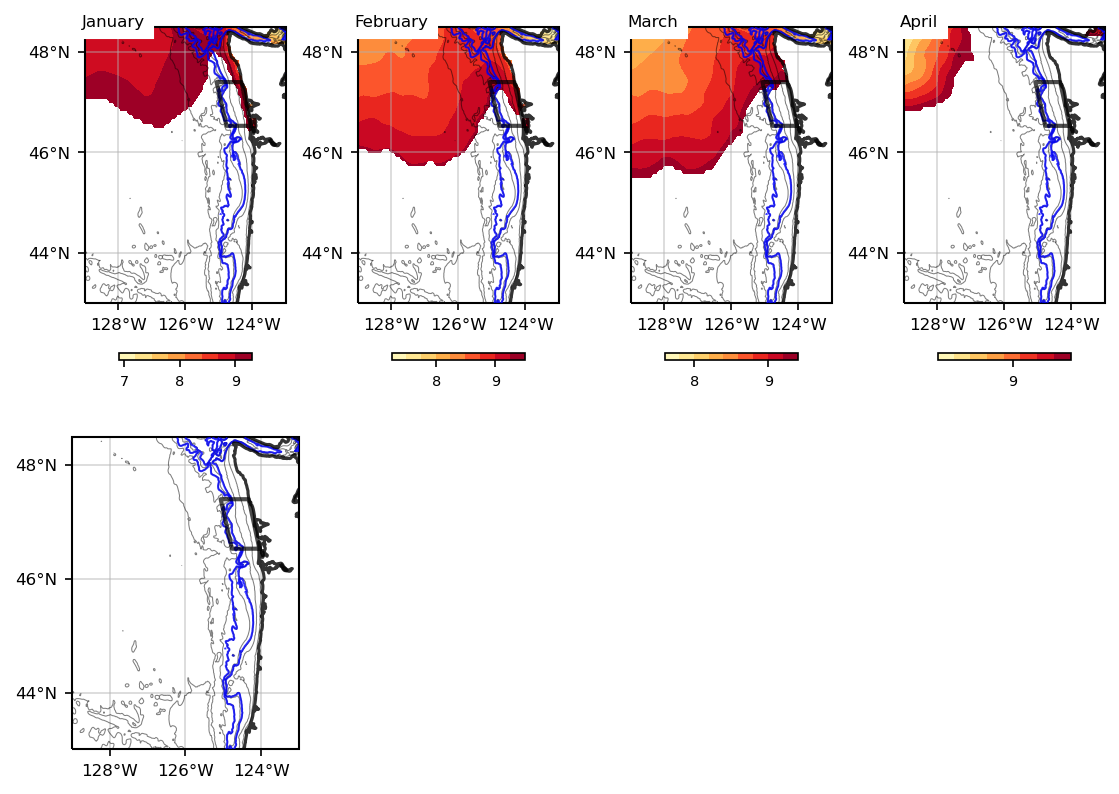

In [9]:
ldp2 = ldp+'./Glorys_Model/'
for v in ['thetao','o2']:
    for de in ['surface','bottom']:
        clim_habitat(v, de, qin)
